Aim of this project is to build a collaborative filtering based recommender system with an Amazon Review based dataset

1. Problem statement\
Our goal is to display a list of objects recommended based on the previous ratings of a user

The dataset includes information about:
- userId: Every user identified with a unique id
- productId: Every product identified with a unique id
- Rating: Rating of the corresponding product by the corresponding user
- timestamp: Time of the rating (ignore this column for this exercise)

In [2]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import scipy

2. Data collection

Dataset source: https://www.kaggle.com/datasets/saurav9786/amazon-product-reviews

In [3]:
df = pd.read_csv("..\\content\\ratings_Electronics.csv", names=["userID", "productID", "Rating", "timestamp"])

In [4]:
df.head()

,userID,productID,Rating,timestamp
0,AKM1MP6P0OYPR,0132793040,5.0,1365811200
1,A2CX7LUOHB2NDG,0321732944,5.0,1341100800
2,A2NWSAGRHCP8N5,0439886341,1.0,1367193600
3,A2WNBOD3WNDNKT,0439886341,3.0,1374451200
4,A1GI0U4ZRJA8WN,0439886341,1.0,1334707200


In [5]:
# Display the titles of the columns
df.keys()

Index(['userID', 'productID', 'Rating', 'timestamp'], dtype='object')

In [6]:
df.shape

(7824482, 4)

3. Data checks

In [7]:
# Count missing values (null)
df.isnull().sum()

userID       0
productID    0
Rating       0
timestamp    0
dtype: int64

In [8]:
# Count missing values (empty strings)
df.eq(' ').sum()

userID       0
productID    0
Rating       0
timestamp    0
dtype: int64

In [9]:
# Look for missing values
df.isna().sum()

userID       0
productID    0
Rating       0
timestamp    0
dtype: int64

In [10]:
# Check for dupicates
df.duplicated().sum()

0

In [11]:
df.loc[df.duplicated()]

,userID,productID,Rating,timestamp


3.2 Check datatypes

In [12]:
# Infos about the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7824482 entries, 0 to 7824481
Data columns (total 4 columns):
 #   Column     Dtype  
---  ------     -----  
 0   userID     object 
 1   productID  object 
 2   Rating     float64
 3   timestamp  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 238.8+ MB


The timestamp is in seconds but we could change it into a date that can be readable for a user

In [13]:
from datetime import datetime
test_date = datetime.fromtimestamp(df["timestamp"][1]).strftime("%A, %B %d, %Y %I:%M:%S")
test_date

'Sunday, July 01, 2012 02:00:00'

In [14]:
df["timestamp_date"] = pd.to_datetime(df["timestamp"], unit='s')

In [15]:
df.head()

,userID,productID,Rating,timestamp,timestamp_date
0,AKM1MP6P0OYPR,0132793040,5.0,1365811200,2013-04-13
1,A2CX7LUOHB2NDG,0321732944,5.0,1341100800,2012-07-01
2,A2NWSAGRHCP8N5,0439886341,1.0,1367193600,2013-04-29
3,A2WNBOD3WNDNKT,0439886341,3.0,1374451200,2013-07-22
4,A1GI0U4ZRJA8WN,0439886341,1.0,1334707200,2012-04-18


In [16]:
# Checking the number of unique values of each column
df.nunique()

userID            4201696
productID          476002
Rating                  5
timestamp            5489
timestamp_date       5489
dtype: int64

In [17]:
# We can use the column customerID to check for unique entries in the dataset
print(df['userID'].nunique() == df.shape[0])

False


This means that at least some customers have posted multiple ratings which is convenient for our project

3.3 Check datasets' statistics

In [18]:
# I want to show the most extreme pourcentiles to display the extreme values that can be either very informatives of very annoying
pourcentiles = [.25, .50, .75, .95, .99]
df["Rating"].describe(percentiles=pourcentiles, )

count    7.824482e+06
mean     4.012337e+00
std      1.380910e+00
min      1.000000e+00
25%      3.000000e+00
50%      5.000000e+00
75%      5.000000e+00
95%      5.000000e+00
99%      5.000000e+00
max      5.000000e+00
Name: Rating, dtype: float64

In this dataset:
- at least 50% of the ratings have the maximum rating
- at least 75% of the ratings are positive

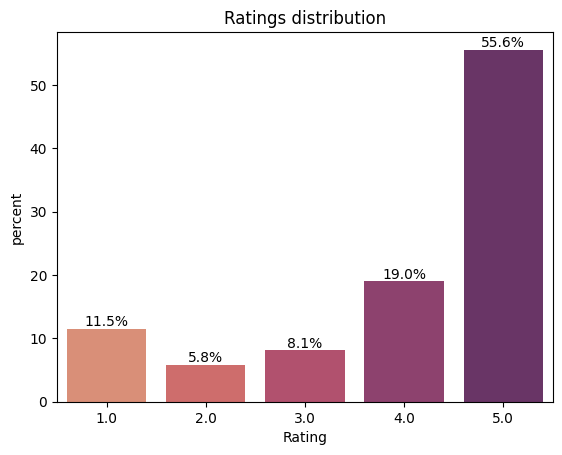

In [19]:
ax = sns.countplot(x='Rating', data=df, palette="flare", stat="percent")
ax.set_title('Ratings distribution')
for bar in range(len(ax.containers)):
    ax.bar_label(ax.containers[bar], fmt='%.1f%%')

Check the number of unique users and products

In [20]:
unique_users = df["userID"].nunique()
unique_products = df["productID"].nunique()

print(f"Number of unique users: {unique_users}")
print(f"Number of unique products: {unique_products}")

Number of unique users: 4201696
Number of unique products: 476002


We could try to keep users who have at least a good number of ratings to make the recommendations more suitable to the taste of the user

In [21]:
ratings_counts = df['userID'].value_counts()

print(f"Number of users with at least 10 ratings: {len(ratings_counts[ratings_counts >= 10])}")

Number of users with at least 10 ratings: 63175


We have less users but we will be able to build a more reliable recommender system for the customers that have the most engagement with the company

In [22]:
new_df = df[df["userID"].isin(ratings_counts[ratings_counts >= 20].index)]

In [30]:
new_df = new_df.drop(labels=["timestamp", "timestamp_date"], axis=1)
new_df

,userID,productID,Rating
17,A1H8PY3QHMQQA0,0528881469,2.0
94,A3BY5KCNQZXV5U,0594451647,5.0
113,A2QBZA4S1ROX9Q,0594481813,3.0
118,AT09WGFUM934H,0594481813,3.0
158,A2E14J26DQZOAA,0777700018,5.0
...,...,...,...
7824444,A2BYV7S1QP2YIG,B00LKG1MC8,5.0
7824448,A13T3S3H9G0J5Z,B00LMCPYPG,2.0
7824449,A20MBPLK731VHY,B00LMCPYPG,1.0
7824459,A2QW4HHHC6XWH4,B00LPQRT34,4.0


In [24]:
ratings_matrix = new_df.pivot(index = 'userID', columns ='productID', values = 'Rating').fillna(0)
print('Shape of final_ratings_matrix: ', ratings_matrix.shape)

Shape of final_ratings_matrix:  (13351, 115394)


In [25]:
np.count_nonzero(ratings_matrix)

452040

In [26]:
def calculate_sparsity(matrix):
    total_elements = matrix.shape[0] * matrix.shape[1]
    sparsity = ((total_elements - np.count_nonzero(matrix))  / total_elements) * 100
    return sparsity

sparsity = calculate_sparsity(ratings_matrix)
sparsity

99.97065866685686

Rank based Recommendation System:
- We sort the items by their respective rating

In [35]:
new_df.head()

,userID,productID,Rating
17,A1H8PY3QHMQQA0,0528881469,2.0
94,A3BY5KCNQZXV5U,0594451647,5.0
113,A2QBZA4S1ROX9Q,0594481813,3.0
118,AT09WGFUM934H,0594481813,3.0
158,A2E14J26DQZOAA,0777700018,5.0


In [41]:
#Calculate the average rating for each product 
average_rating = new_df.groupby(['productID']).mean(numeric_only=True).Rating
# Calculate the number of ratings for each products
count_rating = new_df.groupby(['productID']).count().Rating

In [46]:
#Create a new dataframe
prod_ratings = pd.DataFrame(pd.concat([average_rating, count_rating], axis=1))
prod_ratings.columns=["averageRating", "ratingsCount"]
prod_ratings

,averageRating,ratingsCount
productID,,
0528881469,2.0,1
0594451647,5.0,1
0594481813,3.0,2
0777700018,5.0,1
0970407998,2.5,2
...,...,...
B00LI4ZZO8,4.5,2
B00LKG1MC8,5.0,1
B00LMCPYPG,1.5,2


In [49]:
sort_list = ['averageRating', "ratingsCount"]
prod_ratings = prod_ratings.sort_values(by=sort_list, ascending=False)
prod_ratings.head()

,averageRating,ratingsCount
productID,,
B00HG1L334,5.0,31
B00BEWF4R2,5.0,30
B004SCSV2U,5.0,26
B00IVPU6AA,5.0,23
B000BVC0WO,5.0,22


Build a function for the most popular items 

In [54]:
def top_rated_products(number, min_interaction):
    
    #Finding movies with minimum number of interactions
    recommendations = prod_ratings[prod_ratings['ratingsCount'] >= min_interaction]
    
    #Sorting values average rating 
    recommendations = recommendations.sort_values(by='averageRating', ascending=False)
    
    return recommendations.index[:number]

top_rated_products(150, 30)

Index(['B00HG1L334', 'B00BEWF4R2', 'B001W26TIW', 'B004EBUXHQ', 'B000F7QRTG',
       'B004FA8NOQ', 'B0033PRWSW', 'B001TH7GUA', 'B009WA115M', 'B001N9X4CS',
       ...
       'B009GUXU52', 'B0001CNMFM', 'B004TLIVB6', 'B0093HGD2K', 'B00484IEJS',
       'B001BM5XB2', 'B004AGX4YO', 'B00B1862X4', 'B002K9IHGI', 'B000CRFOMK'],
      dtype='object', name='productID', length=150)

We will try to deal with the sparsity of the matrix using SVD\
Source: https://medium.com/@aliozan_memetoglu/5-dealing-with-sparsity-and-matrix-factorization-2df425bc2fae


In [ ]:
exp_ratings_matrix = new_df.pivot(index = 'userID', columns ='productID', values = 'Rating')

In [ ]:
avg_ratings = exp_ratings_matrix.mean(axis=1)

In [ ]:
# Center each users ratings around 0
user_ratings_table_centered = exp_ratings_matrix.sub(avg_ratings, axis=0)

In [ ]:
user_ratings_table_normed = user_ratings_table_centered.fillna(0)

In [ ]:
# Change the dataframe into a numpy array
np_ratings_matrix = user_ratings_table_normed.to_numpy()

In [ ]:
from scipy.sparse.linalg import svds
# Decompose the matrix
U, sigma, Vt = svds(np_ratings_matrix)

In [ ]:
sigma

In [ ]:
# Convert sigma into a diagonal matrix
sigma = np.diag(sigma)
print(sigma)

In [ ]:
# Dot product of U and sigma
U_sigma = np.dot(U, sigma)
# Dot product of result and Vt
U_sigma_Vt = np.dot(U_sigma, Vt)
# Add back on the row means contained in avg_ratings
uncentered_ratings = U_sigma_Vt + avg_ratings.values.reshape(-1, 1)
# Create DataFrame of the results
calc_pred_ratings_df = pd.DataFrame(uncentered_ratings, 
                                    index=exp_ratings_matrix.index,
                                    columns=exp_ratings_matrix.columns
                                   )
# Print both the recalculated matrix and the original 
print(calc_pred_ratings_df)